# Loading packages 

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.preprocessing import PowerTransformer, StandardScaler
import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from IPython.display import Image
pd.set_option("display.max_columns", None)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
%load_ext pycodestyle_magic
%pycodestyle_on

# Database representation

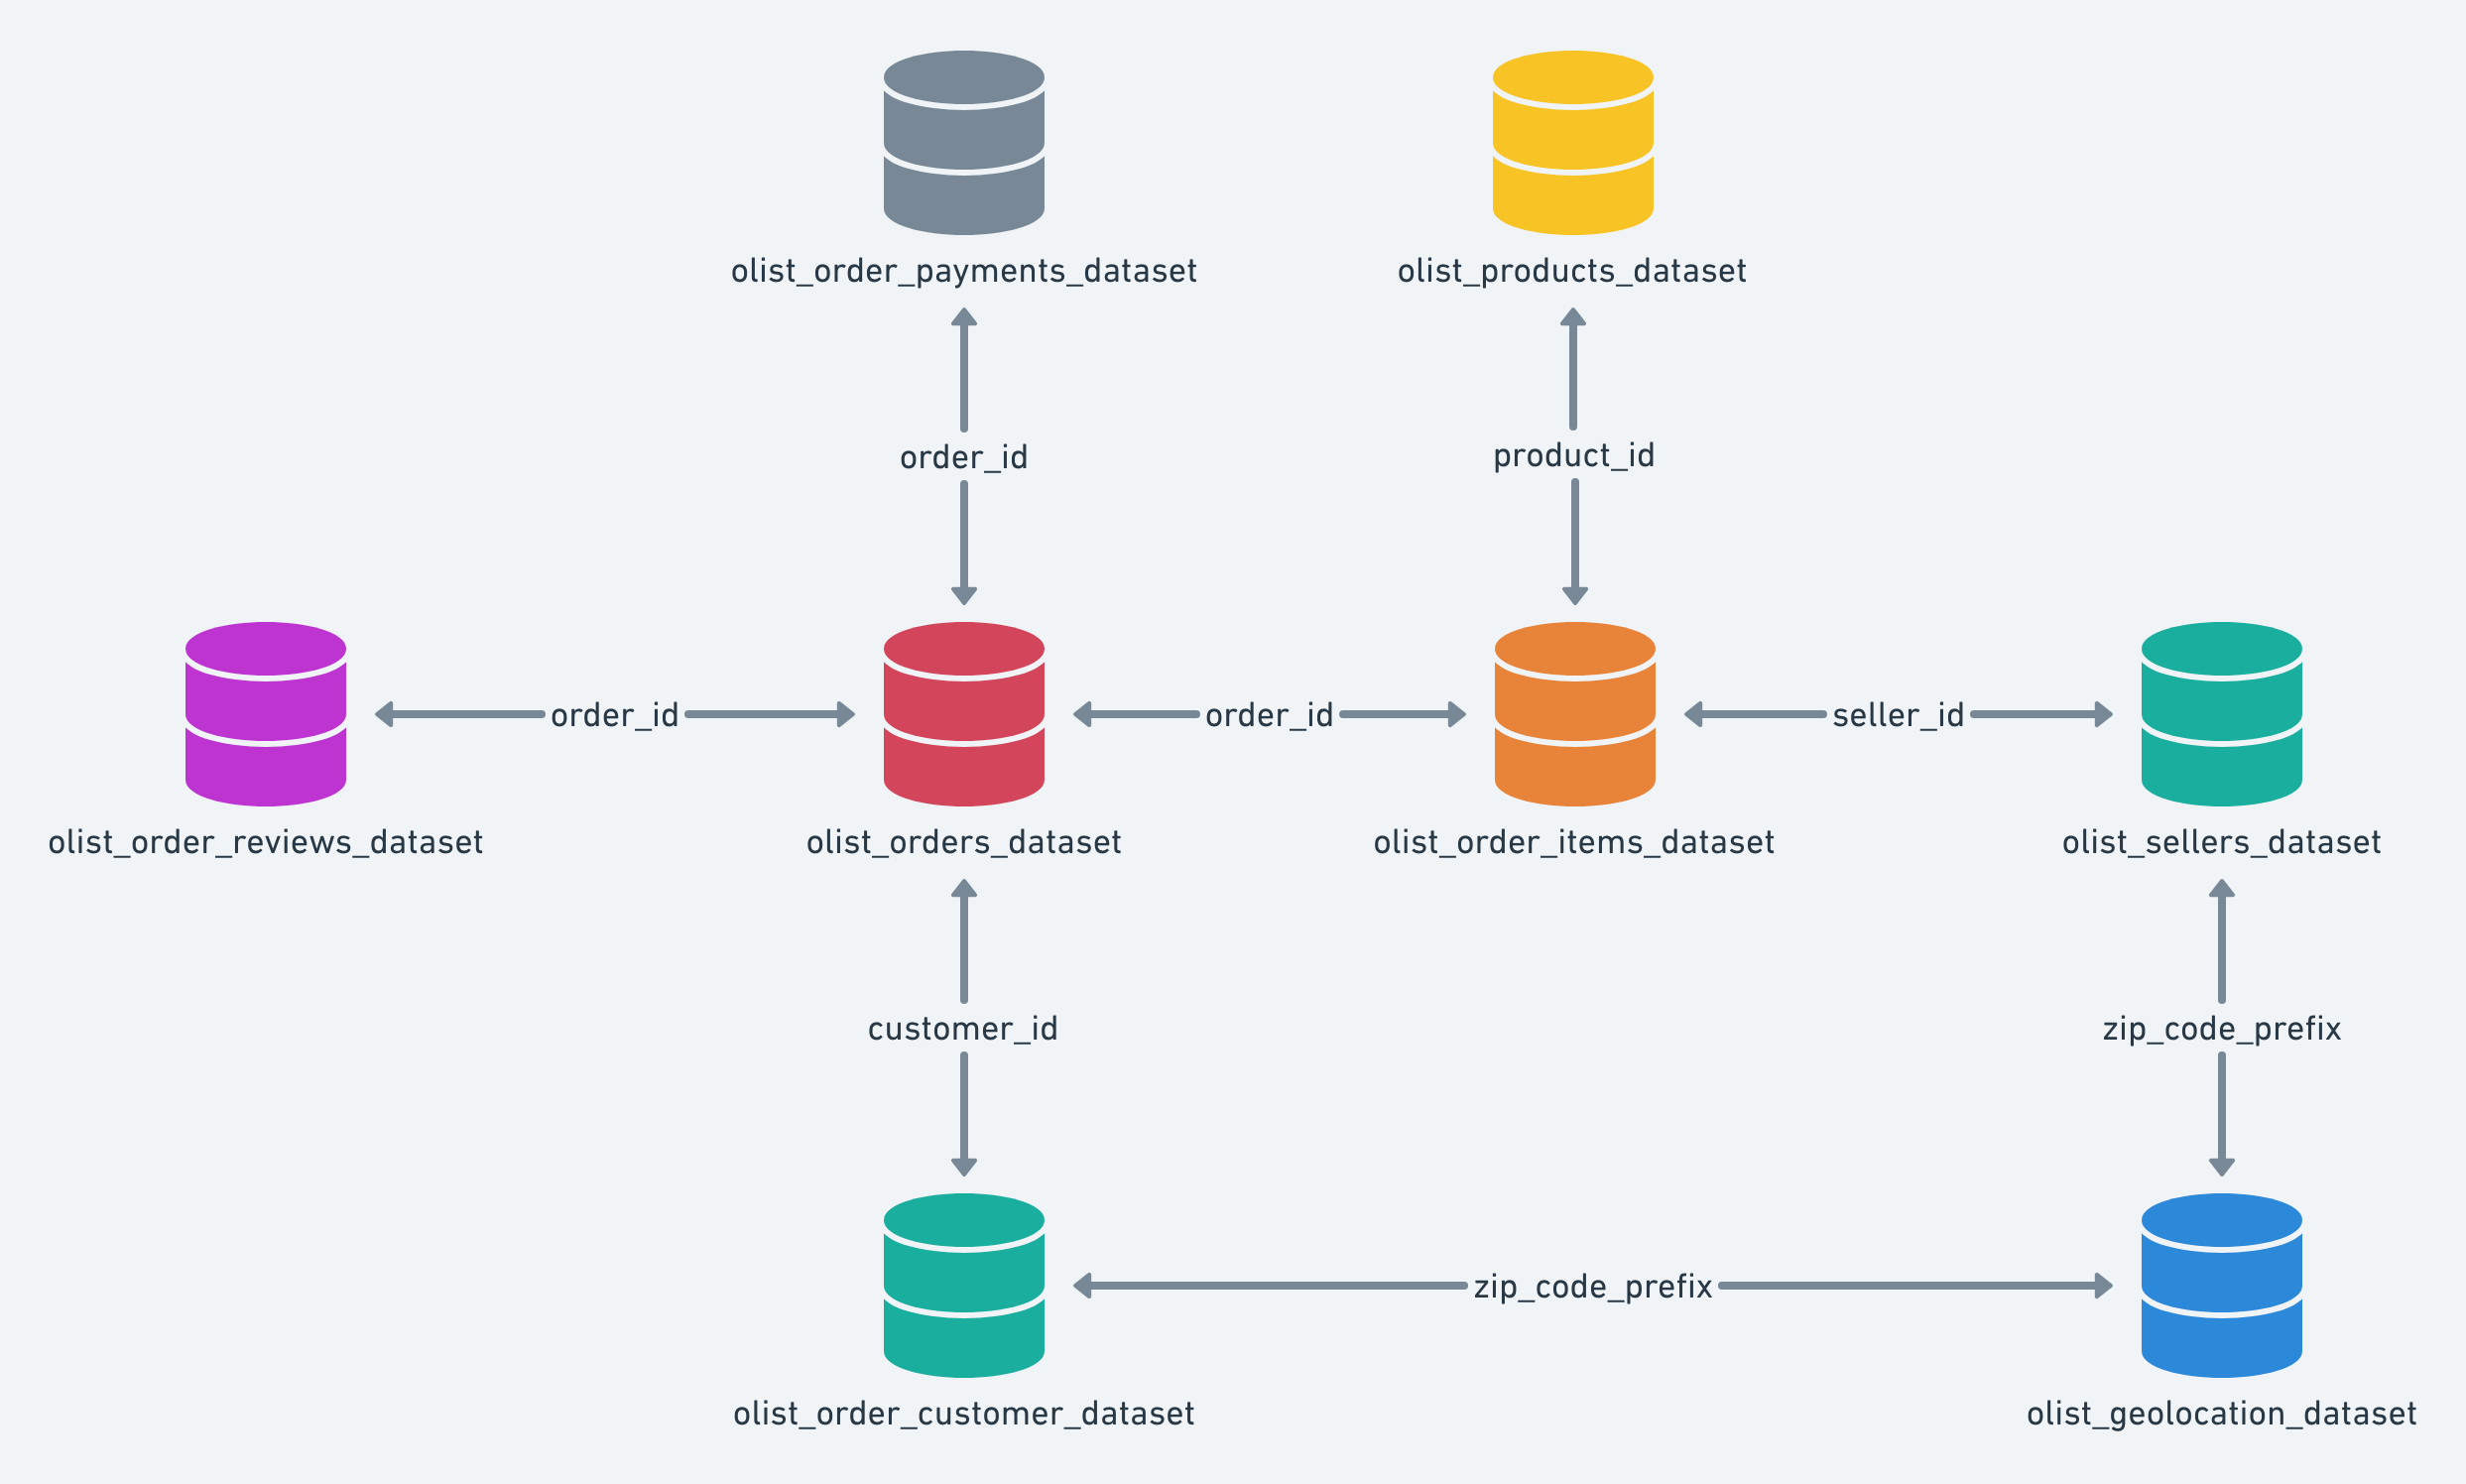

In [2]:
Image(filename='images/database_schema.png', width=800)

# Products dataset & product category name translation

In [3]:
# Products dataset
products = pd.read_csv("datasets/olist_products_dataset.csv")

# Category name translation
category_name_translation = pd.read_csv(
    "datasets/product_category_name_translation.csv")

print("products shape:", products.shape)
display(products.head(3))

print("category_name_translation shape:", category_name_translation.shape)
display(category_name_translation.head(3))

products shape: (32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


category_name_translation shape: (71, 2)


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto


In [4]:
# Merge products table with category_name_translation table
products = pd.merge(products,
                    category_name_translation,
                    how='left',
                    on='product_category_name')

# Drop unnecessary features
products = products.drop(['product_category_name',
                          'product_length_cm',
                          'product_height_cm',
                          'product_width_cm',
                          'product_weight_g'], axis=1)
# Rename a feature
products.rename(columns={'product_category_name_english':
                         'product_category_name'}, inplace=True)

# Convert feature type to str
products['product_category_name'] = products['product_category_name'].\
                                    astype(str)

# Display the first five rows
products.head(3)

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,sports_leisure


# Order items dataset

In [5]:
order_items = pd.read_csv("datasets/olist_order_items_dataset.csv")

In [6]:
print("order_items shape:", order_items.shape)
order_items.head(3)

order_items shape: (112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [7]:
# Example of orders containing several items
order_items[order_items.duplicated(subset=['order_id'], keep=False)].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10


In [8]:
# Dictionary containing appropriate aggregations
order_items_agg = {
    # Number of items in the order
    'order_item_id': 'max',
    # Number of distinct items in the order
    'product_id': 'nunique',
    # Total price of the order (without freight value)
    'price': 'sum',
    # Total freight value of the order
    'freight_value': 'sum',
    # Mean product name length of the order
    'product_name_lenght': 'mean',
    # Mean product description length of the order
    'product_description_lenght': 'mean',
    # Mean number of pictures associated with the order
    'product_photos_qty': 'mean',
    # Category of products for each item of the order
    'product_category_name': lambda x: ', '.join(x.unique()),
}

# Merge order_items table with products table
order_items = pd.merge(order_items, products, how='left', on='product_id')

# Group rows by order and apply appropriate aggregations presented above
order_items_df = order_items.groupby(
    ['order_id'])[list(order_items_agg.keys())].agg(order_items_agg)

# Rename columns
order_items_df = order_items_df.rename(
    columns={'order_item_id': 'nb_items',
             'product_id': 'nb_unique_items',
             'product_name_lenght': 'mean_prod_name_len',
             'product_description_lenght': 'mean_desc_name_len',
             'product_photos_qty': 'mean_photos_qty'})

# Display the five first rows
order_items_df.head()

,nb_items,nb_unique_items,price,freight_value,mean_prod_name_len,mean_desc_name_len,mean_photos_qty,product_category_name
order_id,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,1,58.90,13.29,58.0,598.0,4.0,cool_stuff
00018f77f2f0320c557190d7a144bdd3,1,1,239.90,19.93,56.0,239.0,2.0,pet_shop
000229ec398224ef6ca0657da4fc703e,1,1,199.00,17.87,59.0,695.0,2.0,furniture_decor
00024acbcdf0a6daa1e931b038114c75,1,1,12.99,12.79,42.0,480.0,1.0,perfumery
00042b26cf59d7ce69dfabb4e55b4fd9,1,1,199.90,18.14,59.0,409.0,1.0,garden_tools


Some orders may contains several items, with items belonging to different category of products :

In [9]:
several_cat_orders = order_items_df['product_category_name'].str.contains(', ')
order_items_df[several_cat_orders].head()

,nb_items,nb_unique_items,price,freight_value,mean_prod_name_len,mean_desc_name_len,mean_photos_qty,product_category_name
order_id,,,,,,,,
002f98c0f7efd42638ed6100ca699b42,2,2,53.89,39.73,44.500000,408.500000,2.500000,"consoles_games, toys"
005d9a5423d47281ac463a968b3936fb,3,2,99.97,45.28,48.666667,309.666667,1.333333,"toys, baby"
014405982914c2cde2796ddcf0b8703d,2,2,49.23,29.20,41.000000,820.000000,1.000000,"perfumery, sports_leisure"
01b1a7fdae9ad1837d6ab861705a1fa5,2,2,108.99,26.85,47.500000,483.000000,2.500000,"bed_bath_table, housewares"
01cce1175ac3c4a450e3a0f856d02734,2,2,96.23,27.51,56.000000,587.000000,2.000000,"garden_tools, stationery"


# Order payments dataset

In [10]:
order_payments = pd.read_csv("datasets/olist_order_payments_dataset.csv")

In [11]:
print("order_payments shape: ", order_payments.shape)
order_payments.head()

order_payments shape:  (103886, 5)


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Let's see the existing types of payment :

In [12]:
order_payments['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

Let's investigate the three orders without a defined payment type : 

In [13]:
order_payments[order_payments.payment_type == "not_defined"]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0


Let's exclude these three orders :

In [14]:
# Exclude the three orders without a defined payment type
defined_payment_type = order_payments['payment_type'] != 'not_defined'
order_payments = order_payments[defined_payment_type]

# Dictionary containing appropriate aggregations
order_payments_agg = {
    # Number of payment type of the order
    'payment_sequential': 'max',
    # Payement installments (> 1) or not (= 1)
    'payment_installments': 'max',
    # Total cost of the order (price + freight value)
    'payment_value': 'sum',
    # Payment type of the order
    'payment_type': lambda x: ', '.join(x.unique()),
}

# Group rows by order and apply appropriate aggregations presented above
order_payments_df = order_payments.groupby(
    'order_id')[list(order_payments_agg.keys())].agg(order_payments_agg)

# Rename columns
order_payments_df = order_payments_df.rename(
    columns={'payment_sequential': 'payment_type_nb',
             'payment_installments': 'payment_instlmt_nb',
             'payment_value': 'monetary_value',
             'payment_type': 'payment_type'})

# Display the five first rows
order_payments_df.head()

,payment_type_nb,payment_instlmt_nb,monetary_value,payment_type
order_id,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,2,72.19,credit_card
00018f77f2f0320c557190d7a144bdd3,1,3,259.83,credit_card
000229ec398224ef6ca0657da4fc703e,1,5,216.87,credit_card
00024acbcdf0a6daa1e931b038114c75,1,2,25.78,credit_card
00042b26cf59d7ce69dfabb4e55b4fd9,1,3,218.04,credit_card


In [15]:
# Some orders may contains several payment type :
order_payments_df[order_payments_df['payment_type'].str.contains(', ')].head()

,payment_type_nb,payment_instlmt_nb,monetary_value,payment_type
order_id,,,,
0016dfedd97fc2950e388d2971d718c7,2,5,70.55,"voucher, credit_card"
009ac365164f8e06f59d18a08045f6c4,6,1,32.00,"voucher, credit_card"
00b4a910f64f24dbcac04fe54088a443,2,1,50.59,"voucher, credit_card"
00bd50cdd31bd22e9081e6e2d5b3577b,3,1,85.80,"voucher, credit_card"
00c405bd71187154a7846862f585a9d4,7,1,46.69,"voucher, credit_card"


# Order reviews dataset

In [16]:
order_reviews = pd.read_csv("datasets/olist_order_reviews_dataset.csv")
print("order_reviews shape: ", order_reviews.shape)
order_reviews.head(3)

order_reviews shape:  (99224, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [17]:
# Dictionary containing appropriate aggregations
order_reviews_agg = {
    # Mean review score per order
    'review_score': 'mean',
    # Total number of notes per order
    'review_id': 'count',
    # Total number of comments per order
    'review_comment_message': lambda x: x.notnull().sum(),
}

# Group rows by order and apply appropriate aggregations presented above
order_reviews_df = order_reviews.groupby(
    'order_id')[list(order_reviews_agg.keys())].agg(order_reviews_agg)

# Rename columns
order_reviews_df = order_reviews_df.rename(
    columns={'review_score': 'mean_review_score',
             'review_id': 'review_nb',
             'review_comment_message': 'comment_msg_nb'})

order_reviews_df.head()

,mean_review_score,review_nb,comment_msg_nb
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,5.0,1,1
00018f77f2f0320c557190d7a144bdd3,4.0,1,0
000229ec398224ef6ca0657da4fc703e,5.0,1,1
00024acbcdf0a6daa1e931b038114c75,4.0,1,0
00042b26cf59d7ce69dfabb4e55b4fd9,5.0,1,1


# Orders dataset

In [18]:
orders = pd.read_csv("datasets/olist_orders_dataset.csv")
print("orders shape: ", orders.shape)
orders.head(3)

orders shape:  (99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [19]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [20]:
# Let's keep only delivered orders
orders = orders[orders['order_status'] == 'delivered']

# Convert order_purchase_timestamp to datetime format
orders['order_purchase_timestamp'] = pd.to_datetime(
    orders['order_purchase_timestamp'])

# Change order of features within dataset
orders_df = orders[['order_id', 'customer_id', 'order_purchase_timestamp']]

# Display the five first rows
orders_df.head()

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39


# Customers dataset

In [21]:
customers = pd.read_csv("datasets/olist_customers_dataset.csv")
print("customers shape: ", customers.shape)
customers.head(3)

customers shape:  (99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


# Geolocation dataset

In [22]:
geolocation = pd.read_csv("datasets/olist_geolocation_dataset.csv")
geolocation_df = geolocation.groupby('geolocation_zip_code_prefix')[
    ['geolocation_lat', 'geolocation_lng']].median().reset_index()
geolocation_df.columns = ['zip_code_prefix', 'latitude', 'longitude']
# Median latitude and longitude per zipcode
geolocation_df.head(3)

,zip_code_prefix,latitude,longitude
0,1001,-23.550381,-46.634027
1,1002,-23.548551,-46.635072
2,1003,-23.548977,-46.635313


In [23]:
# Let's merge customers dataset with geolocation dataset
customers = customers.merge(geolocation_df,
                            left_on='customer_zip_code_prefix',
                            right_on='zip_code_prefix')
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,zip_code_prefix,latitude,longitude
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409,-20.50207,-47.396822
1,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,14409,franca,SP,14409,-20.50207,-47.396822
2,661897d4968f1b59bfff74c7eb2eb4fc,d06a495406b79cb8203ea21cc0942f8c,14409,franca,SP,14409,-20.50207,-47.396822


Customers dataset contains two features corresponding to customer ID : `customer_id` and `customer_unique_id`

In [24]:
customers.apply(lambda x: x.nunique())

customer_id                 99163
customer_unique_id          95828
customer_zip_code_prefix    14837
customer_city                4074
customer_state                 27
zip_code_prefix             14837
latitude                    14833
longitude                   14832
dtype: int64

__Assumption :__ Some customers purchased more than one time, so we will consider `customer_unique_id` as our customer ID.

In [25]:
frequency = customers.groupby('customer_unique_id')['customer_id'].size()
several_purchases = len(frequency[frequency > 1])
one_purchase = len(frequency[frequency == 1])
print("Customers who purchased more than one time :", several_purchases)
print("Prop of customers who purchased more than one time :",
      several_purchases/(several_purchases + one_purchase))

col = ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'latitude', 'longitude']

customers_df = customers[col]
customers_df.head(3)

Customers who purchased more than one time : 2988
Prop of customers who purchased more than one time : 0.031180865717744293


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,latitude,longitude
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.50207,-47.396822
1,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,14409,franca,SP,-20.50207,-47.396822
2,661897d4968f1b59bfff74c7eb2eb4fc,d06a495406b79cb8203ea21cc0942f8c,14409,franca,SP,-20.50207,-47.396822


# Gathering datasets 

In [26]:
customers_orders_df = orders_df.merge(
    order_items_df, on='order_id').merge(
    order_reviews_df, on='order_id').merge(
    order_payments_df, on='order_id').merge(
    customers_df, on='customer_id')

print("customers_orders_df shape: ", customers_orders_df.shape)
customers_orders_df.head(3)

customers_orders_df shape:  (95568, 24)


,order_id,customer_id,order_purchase_timestamp,nb_items,nb_unique_items,price,freight_value,mean_prod_name_len,mean_desc_name_len,mean_photos_qty,product_category_name,mean_review_score,review_nb,comment_msg_nb,payment_type_nb,payment_instlmt_nb,monetary_value,payment_type,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,latitude,longitude
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,1,1,29.99,8.72,40.0,268.0,4.0,housewares,4.0,1,1,3,1,38.71,"credit_card, voucher",7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576170,-46.587276
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,1,1,118.70,22.76,29.0,178.0,1.0,perfumery,4.0,1,1,1,1,141.46,boleto,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.126651,-45.008162
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,1,1,159.90,19.22,46.0,232.0,1.0,auto,5.0,1,0,1,3,179.12,credit_card,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.744472,-48.514624


At this step, the dataset contains duplicated customers, corresponding to customers who purchased more than one time. For these customers, we will keep their most representative order by considering the median value or each numerical attribute.

In [27]:
customer_orders_agg = {
    'mean_desc_name_len': 'median',
    'product_category_name': lambda x: ', '.join(x.unique()),
    'payment_type': lambda x: ', '.join(x.unique()),
    'monetary_value': 'median',
    'mean_review_score': 'median',
    'mean_photos_qty': 'median',
    'order_purchase_timestamp': 'median',
    'nb_items': 'median',
    'nb_unique_items': 'median',
    'price': 'median',
    'freight_value': 'median',
    'mean_prod_name_len': 'median',
    'customer_zip_code_prefix': 'first',
    'customer_city': 'first',
    'customer_state': 'first',
    'review_nb': 'median',
    'comment_msg_nb': 'median',
    'payment_type_nb': 'median',
    'payment_instlmt_nb': 'median',
    'latitude': 'median',
    'longitude': 'median',
    'customer_id': 'count',  # == Frequency
}

final_dataset = customers_orders_df.groupby(
    'customer_unique_id')[list(customer_orders_agg.keys())].agg(
    customer_orders_agg)

final_dataset = final_dataset.rename(
    columns={'customer_id': 'frequency',
             'total_payment_value': 'monetary_value'})

# == Recency
one_day = datetime.timedelta(days=1)
snapshot_date = max(customers_orders_df.order_purchase_timestamp) + one_day
final_dataset['recency'] = final_dataset['order_purchase_timestamp'].apply(
    lambda x: (snapshot_date - x).days)

# Day, month, hour
final_dataset['day'] = final_dataset['order_purchase_timestamp'].dt.day
final_dataset['month'] = final_dataset['order_purchase_timestamp'].dt.month
final_dataset['hour'] = final_dataset['order_purchase_timestamp'].dt.hour

# Drop order_purchase_timestamp
final_dataset['order_date'] = final_dataset[
    'order_purchase_timestamp'].dt.strftime('%Y-%m-%d')

# Convert zip code to str
final_dataset['customer_zip_code_prefix'] = final_dataset[
    'customer_zip_code_prefix'].astype(str)

# Remove rows with missing values (~1K)
final_dataset = final_dataset.dropna()


def get_unique_p_types(s):
    '''Function to remove duplicated payment type.'''
    return ', '.join(list(set(s.split(', '))))


final_dataset['payment_type'] = final_dataset.payment_type.apply(
    get_unique_p_types)

print("final_dataset shape :", final_dataset.shape)
final_dataset.head(3)

final_dataset shape : (91252, 27)


,mean_desc_name_len,product_category_name,payment_type,monetary_value,mean_review_score,mean_photos_qty,order_purchase_timestamp,nb_items,nb_unique_items,price,freight_value,mean_prod_name_len,customer_zip_code_prefix,customer_city,customer_state,review_nb,comment_msg_nb,payment_type_nb,payment_instlmt_nb,latitude,longitude,frequency,recency,day,month,hour,order_date
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,236.0,bed_bath_table,credit_card,141.90,5.0,1.0,2018-05-10 10:56:27,1.0,1.0,129.9,12.00,60.0,7787,cajamar,SP,1.0,1.0,1.0,8.0,-23.337679,-46.826739,1,112,10,5,10,2018-05-10
0000b849f77a49e4a4ce2b2a4ca5be3f,635.0,health_beauty,credit_card,27.19,4.0,1.0,2018-05-07 11:11:27,1.0,1.0,18.9,8.29,56.0,6053,osasco,SP,1.0,0.0,1.0,1.0,-23.557876,-46.788754,1,115,7,5,11,2018-05-07
0000f46a3911fa3c0805444483337064,177.0,stationery,credit_card,86.22,3.0,3.0,2017-03-10 21:05:03,1.0,1.0,69.0,17.22,49.0,88115,sao jose,SC,1.0,0.0,1.0,8.0,-27.543787,-48.631973,1,537,10,3,21,2017-03-10


# EDA

## Univariate analysis

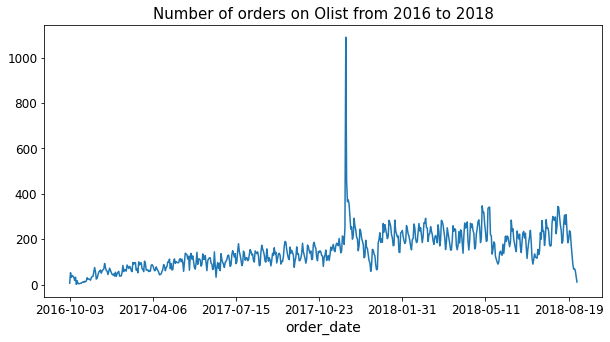

In [28]:
final_dataset.groupby('order_date').size().plot(figsize=(10, 5))
plt.title("Number of orders on Olist from 2016 to 2018", fontsize=15)
plt.show()

In [29]:
final_dataset = final_dataset.drop(['order_purchase_timestamp',
                                    'order_date'], axis=1)

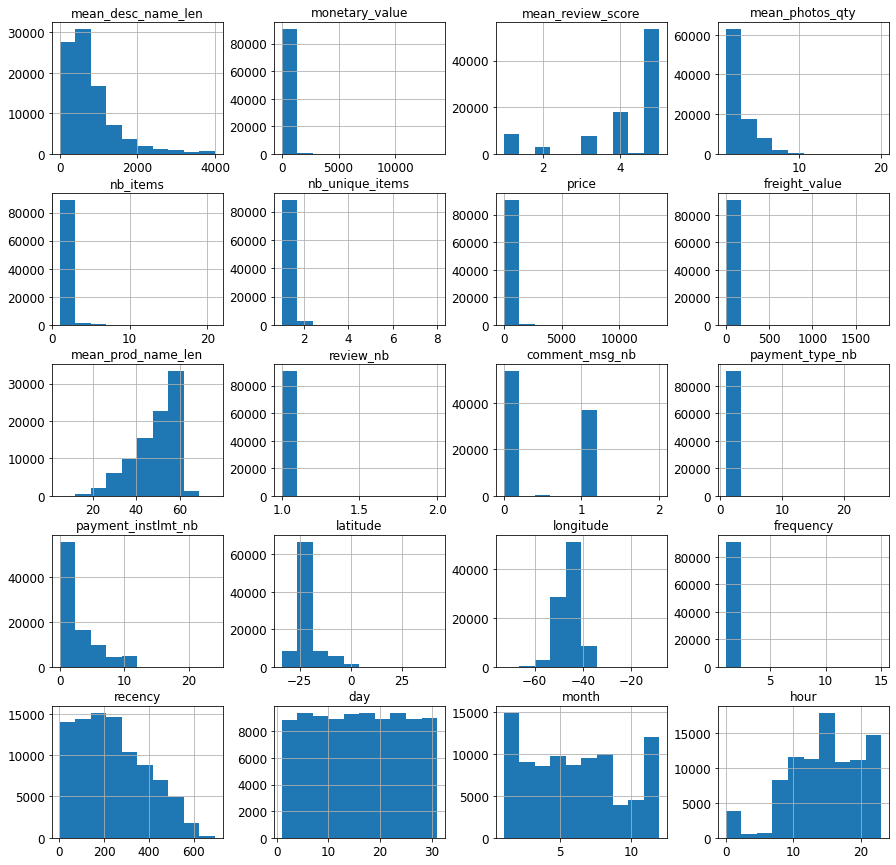

In [30]:
final_dataset.select_dtypes(exclude='object').hist(
    figsize=(15, 15), bins=10)
plt.show()

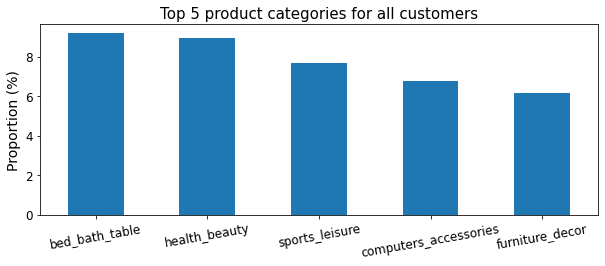

In [32]:
final_dataset['product_category_name'].value_counts(
    normalize=True).head().mul(100).plot(
    figsize=(10, 3.5), kind='bar')
plt.xticks(rotation=10)
plt.title("Top 5 product categories for all customers", fontsize=15)
plt.ylabel("Proportion (%)")
plt.show()

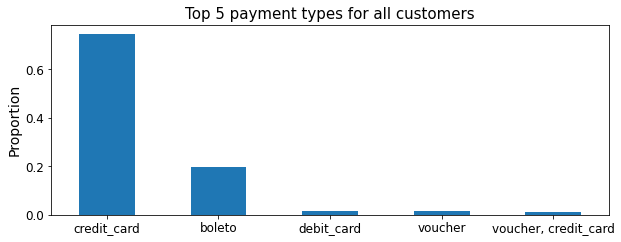

In [60]:
final_dataset['payment_type'].value_counts(
    normalize=True).head().plot(
    figsize=(10, 3.5), kind='bar')
plt.xticks(rotation=0)
plt.title("Top 5 payment types for all customers", fontsize=15)
plt.ylabel("Proportion")
plt.show()

In [31]:
# Descriptive statistics
final_dataset.select_dtypes(exclude='object').agg(
    ['mean', 'std', 'min', 'max']).T

,mean,std,min,max
mean_desc_name_len,795.333323,650.254754,4.000000,3992.000000
monetary_value,160.216282,218.246741,9.590000,13664.080000
mean_review_score,4.154940,1.279082,1.000000,5.000000
mean_photos_qty,2.256454,1.737256,1.000000,20.000000
nb_items,1.139016,0.523722,1.000000,21.000000
nb_unique_items,1.037413,0.221569,1.000000,8.000000
price,137.388778,208.529559,0.850000,13440.000000
freight_value,22.795094,21.503580,0.000000,1794.960000
mean_prod_name_len,48.871968,9.889223,5.000000,76.000000
review_nb,1.003145,0.050106,1.000000,2.000000


## Bivariate analysis (linear relationship)

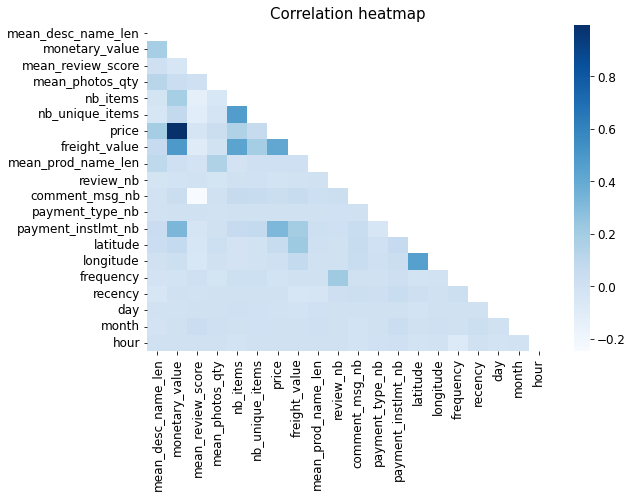

In [32]:
# Pearson correlation
plt.figure(figsize=(9, 6))
corr = final_dataset.select_dtypes(exclude='object').corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap="Blues")
plt.title("Correlation heatmap", fontsize=15)
plt.show()

## Multivariate Analysis - PCA

In [38]:
# Select only numerical variables
X = final_dataset.select_dtypes(exclude='object').values

# Scale them
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Derive cumulative explained variance ratio
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum = np.insert(cumsum, 0, 0)
d = np.argmax(cumsum >= 0.95)
cumsum

array([0.        , 0.13634939, 0.2145866 , 0.28870363, 0.35095631,
       0.41112764, 0.46824704, 0.52058531, 0.5716078 , 0.62175361,
       0.6712597 , 0.71914301, 0.76313906, 0.80491371, 0.84460615,
       0.8830005 , 0.92028677, 0.95353401, 0.98041462, 0.99999931,
       1.        ])

In [39]:
d  # Nb of components explaining 95% of variance

17

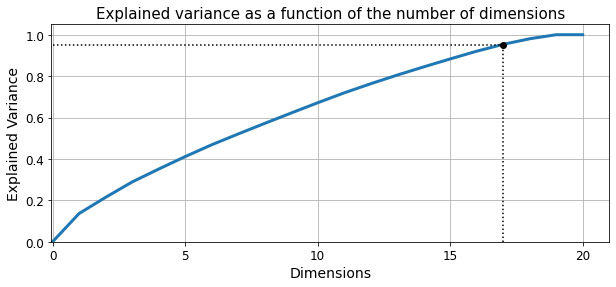

In [40]:
plt.figure(figsize=(10, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([-0.05, len(cumsum), 0, 1.05])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.xticks(range(0, 21, 5))
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.grid(True)
plt.title("Explained variance as a function of the number of dimensions",
          fontsize=15)
plt.show()

In [38]:
final_dataset.to_csv('datasets/clustering_dataset.csv', index=True)